# 데이터

In [41]:
# 라이브러리 불러오기
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

import re
from collections import Counter
import sentencepiece as spm
from konlpy.tag import Okt
from konlpy.tag import Mecab
import csv 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
import tensorflow_addons as tfa
from itertools import combinations
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix
)

from keras.utils.vis_utils import plot_model

In [2]:
# 한글 폰트에 문제가 생겼을 때

# 한글 폰트 설치
!apt-get update -qq
!apt-get install -qq fonts-nanum

# 설치한 폰트를 matplotlib에서 사용할 수 있도록 설정
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

# 나눔 폰트 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# 폰트 매니저에 폰트 추가
fm.fontManager.addfont(font_path)
plt.rc('font', family='NanumGothic')  # 폰트 설정

## 데이터 업로드

#### 학습 데이터 불러오기

프롬프트로 생성된 '일반 대화' 합성 데이터와 원본 데이터가 합쳐진 파일

In [3]:
train_data_path ="/aiffel/aiffel/dlthon-minions/share/data/conversations.csv"
train_data = pd.read_csv(train_data_path)
# 원본 데이터 저장
origin_data = train_data

In [4]:
train_data.sample(10)

,idx,class,conversation
3634,3634,갈취 대화,야 담배 하나만.\n네?\n거기 담배 내놔봐.\n나한테 맡겨놓으셨어요?\n내놔라고....
1610,1610,갈취 대화,씨 시계 좋아보인다. 어디서 샀어?\n 지난 번에 면세점에서 샀어요? 예뻐요?\n ...
2715,2715,협박 대화,어머 이게 누구야 오랜만이네\n아니 너는?\n너? 그때 니가 덜맞았나보네 정신을 못...
4272,4272,일반 대화,"요리하는 거 즐겨?\n응, 새로운 요리 도전하는 게 재밌어.\n요즘 무슨 취미 있어..."
67,67,협박 대화,이 버튼 하나면 건물이 무너질 겁니다.\n뭐라고?\n십 년 전 성당에서처럼 달려보시...
1223,1223,갈취 대화,현우야 나 7만원만 빌려주라\n 동우야 저번에도 10만원 빌렸잖아\n 야 현우야 그...
1701,1701,협박 대화,야 넌 죽어야돼 알어?\n 무슨 말이야 내가 뭘 했다고?\n정말 몰라서 물어 니가 ...
2416,2416,일반 대화,"여행 가고 싶다.\n그러게, 빨리 계획 세우자.\n휴가 언제 가?\n다음 달에 가...."
3364,3364,협박 대화,운전을 그렇게 하면 어떡해???\n아저씨 왜 반말하세요?\n나보다 어리니깐 반말하지...
2709,2709,기타 괴롭힘 대화,왜 이렇게 안내려 오죠?\n15층에서 누가 잡고 있나봐요.\n에이. 바쁜데. 왜 이...


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4950 entries, 0 to 4949
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   idx           4950 non-null   int64 
 1   class         4950 non-null   object
 2   conversation  4950 non-null   object
dtypes: int64(1), object(2)
memory usage: 116.1+ KB


## 전처리

### 기본 전처리

#### 중복값 여부 찾아보기

In [6]:
# 중복값 찾기
duplicates = train_data[train_data.duplicated()]
duplicates

,idx,class,conversation


중복값 없음

#### 결측치 여부 확인하기

In [7]:
# 결측치 여부 확인하기
train_data.isnull().sum()

idx             0
class           0
conversation    0
dtype: int64

결측치 없음

#### 클래스 컬럼 인코딩하기

In [8]:
# 'class'를 'type'으로 매핑하는 딕셔너리 생성하기
class_to_type = {
    '협박 대화': 0,
    '갈취 대화': 1,
    '직장 내 괴롭힘 대화': 2,
    '기타 괴롭힘 대화': 3,
    '일반 대화': 4
}

In [9]:
# 'class' 열을 기반으로 새로운 'type' 열 추가하기
train_data['type'] = train_data['class'].map(class_to_type)

In [10]:
# type 열 추가했는지 확인하기
train_data.head()

,idx,class,conversation,type
0,0,일반 대화,"학교 점심 뭐 나와?\n주로 한식이 나와.\n학원 다녀?\n응, 영어 학원 다녀.\...",4
1,1,기타 괴롭힘 대화,어이 거기 뒤뚱거리는 놈 \n나?\n그래 너 여기 뒤뚱거리는 놈이 너밖에 더 있냐?...,3
2,2,협박 대화,너 그따위로 운전하면 확 갈아마셔버린다.\n 뭐라구?\n 나와 이 자식아. 미안하단...,0
3,3,직장 내 괴롭힘 대화,길동씨 이번에 이것좀 처리해요\n이거 제가 한게 아닌데요\n팀에서 내가 니가가 어딨...,2
4,4,일반 대화,"비가 많이 오네.\n우산 가져왔어?\n날씨가 추워졌어.\n맞아, 이제 겨울이야.\n...",4


In [11]:
# 기존 idx, class 컬럼 삭제하기
new_train_data = train_data.drop(['idx', 'class'], axis=1)
# idx, class 컬럼 삭제했는지 확인하기
new_train_data.head()

,conversation,type
0,"학교 점심 뭐 나와?\n주로 한식이 나와.\n학원 다녀?\n응, 영어 학원 다녀.\...",4
1,어이 거기 뒤뚱거리는 놈 \n나?\n그래 너 여기 뒤뚱거리는 놈이 너밖에 더 있냐?...,3
2,너 그따위로 운전하면 확 갈아마셔버린다.\n 뭐라구?\n 나와 이 자식아. 미안하단...,0
3,길동씨 이번에 이것좀 처리해요\n이거 제가 한게 아닌데요\n팀에서 내가 니가가 어딨...,2
4,"비가 많이 오네.\n우산 가져왔어?\n날씨가 추워졌어.\n맞아, 이제 겨울이야.\n...",4


In [12]:
# new_train_data를 train_data에 덮어 씌우기
train_data = new_train_data

### 텍스트 전처리

#### 한글 외 문자 삭제
한글, '?', '!', '.', '.', 공백 유지

In [13]:
# 전처리 함수
def preprocess_sentence(sentence): 
    # \n을 공백으로 바꾸기
    sentence = re.sub("\n", " ", sentence)
    
    # (ㄱ-ㅎ, ㅏ-ㅣ, ".", "?", "!", ",", ' ')를 제외한 모든 문자를 없애기
    sentence = re.sub("[^ㄱ-ㅣ가-힣.?!, ]", "", sentence)
    
    # 단어와 구두점(punctuation) 사이에 공백 추가
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    
    return sentence

In [14]:
# 전처리 데이터 새로운 column에 저장
train_data['preprocessed'] = train_data['conversation'].apply(preprocess_sentence)
train_data['preprocessed']

0       학교 점심 뭐 나와 ?  주로 한식이 나와 .  학원 다녀 ?  응 ,  영어 학원...
1       어이 거기 뒤뚱거리는 놈  나 ?  그래 너 여기 뒤뚱거리는 놈이 너밖에 더 있냐 ...
2       너 그따위로 운전하면 확 갈아마셔버린다 .   뭐라구 ?   나와 이 자식아 .  ...
3       길동씨 이번에 이것좀 처리해요 이거 제가 한게 아닌데요 팀에서 내가 니가가 어딨어 ...
4       비가 많이 오네 .  우산 가져왔어 ?  날씨가 추워졌어 .  맞아 ,  이제 겨울...
                              ...                        
4945    오 깡패다 니 지금 뭐라했노 말하는것도 깡패네 닌 죽었다 시키야 어디서 건방지게 아...
4946    이거 니 주민등록증 아니야 ?  잃어버린줄 알았는데 . 고마워 !  고맙긴 뭘 근데...
4947    여행 준비 다 했어 ?  아직 ,  짐 싸는 중이야 .  여행 가방은 다 쌌어 ? ...
4948    그거 사줘 안사주면 죽어버릴거야  이러지마 돈없어 나한테 해준게 뭐있어 !  !  ...
4949    얘들아 .  이 년 몰골좀 봐 .   야 .  너 좀 씻고다녀 .  우웩 너희가 나...
Name: preprocessed, Length: 4950, dtype: object

In [15]:
# 기존 'conversation' column 전처리한 데이터로 바꾸기
train_data['conversation'] = train_data['preprocessed']
train_data.drop('preprocessed', axis=1)

,conversation,type
0,"학교 점심 뭐 나와 ? 주로 한식이 나와 . 학원 다녀 ? 응 , 영어 학원...",4
1,어이 거기 뒤뚱거리는 놈 나 ? 그래 너 여기 뒤뚱거리는 놈이 너밖에 더 있냐 ...,3
2,너 그따위로 운전하면 확 갈아마셔버린다 . 뭐라구 ? 나와 이 자식아 . ...,0
3,길동씨 이번에 이것좀 처리해요 이거 제가 한게 아닌데요 팀에서 내가 니가가 어딨어 ...,2
4,"비가 많이 오네 . 우산 가져왔어 ? 날씨가 추워졌어 . 맞아 , 이제 겨울...",4
...,...,...
4945,오 깡패다 니 지금 뭐라했노 말하는것도 깡패네 닌 죽었다 시키야 어디서 건방지게 아...,0
4946,이거 니 주민등록증 아니야 ? 잃어버린줄 알았는데 . 고마워 ! 고맙긴 뭘 근데...,1
4947,"여행 준비 다 했어 ? 아직 , 짐 싸는 중이야 . 여행 가방은 다 쌌어 ? ...",4
4948,그거 사줘 안사주면 죽어버릴거야 이러지마 돈없어 나한테 해준게 뭐있어 ! ! ...,0


#### 불용어 삭제
[불용어 리스트 출처](https://www.ranks.nl/stopwords/korean)

In [16]:
# 불용어 리스트 불러오기
stopwords_path = "/aiffel/aiffel/dlthon-minions/share/preprocess/ko_stopwords.txt"
with open(stopwords_path, 'r', encoding='utf-8') as file:
    stopwords = file.read().splitlines()

#### 토큰화

```!pip install konlpy```

In [17]:
# 단어사전 크기 20000으로 제한
VOCAB_SIZE=20000

Okt 토크나이저 활용

In [18]:
# Okt로 토큰화
tokenizer=Okt()

def tokenize(conversation, tokenizer):
    return [token for token in tokenizer.morphs(conversation) if token not in stopwords]

# 각 conversation을 토큰화하여 새로운 열 'tokenized'에 저장
train_data['tokenized'] = train_data['conversation'].apply(lambda x: tokenize(x, tokenizer))

#### 단어사전 생성

In [19]:
def create_word_to_index(vocab_path):
    # 인코딩에 활용할 단어사전 딕셔너리 생성
    word_to_index = {}
    with open(vocab_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            line = line.strip()
            tmp = line.split(": ")
            word = tmp[0]
            idx = int(tmp[1])
            word_to_index.update({word: idx})
    return word_to_index

In [21]:
vocab_path = '/aiffel/aiffel/dlthon-minions/share/preprocess/vocab.txt'
word_to_index=create_word_to_index(vocab_path)
word_to_index

{'<pad>': 0,
 '<unk>': 1,
 '.': 2,
 '?': 3,
 ',': 4,
 '!': 5,
 '내': 6,
 '해': 7,
 '뭐': 8,
 '는': 9,
 '도': 10,
 '좋아해': 11,
 '거': 12,
 '말': 13,
 '다': 14,
 '은': 15,
 '돈': 16,
 '친구': 17,
 '잘': 18,
 '니': 19,
 '있어': 20,
 '랑': 21,
 '요': 22,
 '영화': 23,
 '만': 24,
 '진짜': 25,
 '이야': 26,
 '정말': 27,
 '죄송합니다': 28,
 '한': 29,
 '게': 30,
 '지금': 31,
 '할': 32,
 '고': 33,
 '하고': 34,
 '한테': 35,
 '오늘': 36,
 '주로': 37,
 '님': 38,
 '주말': 39,
 '그냥': 40,
 '여행': 41,
 '돼': 42,
 '집': 43,
 '많이': 44,
 '자주': 45,
 '제발': 46,
 '가족': 47,
 '알': 48,
 '생각': 49,
 '거야': 50,
 '적': 51,
 '이랑': 52,
 '하는': 53,
 '더': 54,
 '운동': 55,
 '지': 56,
 '그렇게': 57,
 '너무': 58,
 '했어': 59,
 '빨리': 60,
 '회사': 61,
 '새끼': 62,
 '씨': 63,
 '만나': 64,
 '하면': 65,
 '아니야': 66,
 '없어': 67,
 '걸': 68,
 '수': 69,
 '애': 70,
 '면': 71,
 '줄': 72,
 '그런': 73,
 '이렇게': 74,
 '그게': 75,
 '그건': 76,
 '어제': 77,
 '서': 78,
 '이제': 79,
 '넌': 80,
 '대리': 81,
 '인데': 82,
 '사진': 83,
 '나도': 84,
 '엄마': 85,
 '아침': 86,
 '다녀': 87,
 '취미': 88,
 '부모님': 89,
 '만원': 90,
 '싶어': 91,
 '본': 92,
 '뭘': 93,
 '

#### 정수인코딩

In [22]:
# 'tokenized' 열의 데이터를 정수 인코딩
def encode_tokens(tokens, word_to_index):
    unk_index = word_to_index['<unk>']
    return [word_to_index.get(token, unk_index) for token in tokens]

train_data['encoded'] = train_data['tokenized'].apply(lambda x: encode_tokens(x, word_to_index))

In [23]:
train_data.sample(3)

,conversation,type,preprocessed,tokenized,encoded
1079,이사님 이 사진 . 모르지 않으실텐데요 ? 이 . 이건 . 이사님이 여기까...,1,이사님 이 사진 . 모르지 않으실텐데요 ? 이 . 이건 . 이사님이 여기까...,"[이사, 님, 사진, ., 모르지, 않으실텐데요, ?, ., 이건, ., 이사, 님...","[1566, 38, 83, 2, 2231, 15447, 3, 2, 186, 2, 1..."
2834,거기 김대리 . 나랑 잠깐 얘기 좀 해 . 네 알겠습니다 . 자기 요새 회사 ...,2,거기 김대리 . 나랑 잠깐 얘기 좀 해 . 네 알겠습니다 . 자기 요새 회사 ...,"[김, 대리, ., 랑, 얘기, 해, ., 알겠습니다, ., 요새, 회사, 내, 안...","[126, 81, 2, 21, 97, 7, 2, 144, 2, 833, 61, 6,..."
2302,너 왜 그렇게 생겼냐 ? 몸에서 시궁창 냄새는 왜 나는거야 ? 왜 갑자기 시비야...,3,너 왜 그렇게 생겼냐 ? 몸에서 시궁창 냄새는 왜 나는거야 ? 왜 갑자기 시비야...,"[그렇게, 생겼냐, ?, 몸, 시궁창, 냄새, 는, 나는거야, ?, 갑자기, 시비,...","[57, 2067, 3, 310, 3920, 268, 9, 18908, 3, 236..."


## 전처리 후 분석

#### 패딩 적용

In [24]:
# 대화 최대 길이 150으로 설정
MAX_LENGTH = 150

In [25]:
X = pad_sequences(train_data['encoded'], maxlen=MAX_LENGTH, padding='post', truncating='post')

## 데이터 분할

In [26]:
y = train_data['type']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, shuffle=True, random_state=42)

print('훈련 데이터의 개수 :', len(X_train))
print('훈련 레이블의 개수 :', len(y_train))
print('검증 데이터의 개수 :', len(X_val))
print('검증 레이블의 개수 :', len(y_val))
print('테스트 데이터의 개수 :', len(X_test))
print('테스트 레이블의 개수 :', len(y_test))

훈련 데이터의 개수 : 3960
훈련 레이블의 개수 : 3960
검증 데이터의 개수 : 495
검증 레이블의 개수 : 495
테스트 데이터의 개수 : 495
테스트 레이블의 개수 : 495


In [27]:
# 테스트 데이터셋 클래스 불균형 확인
counter = Counter(y_test)
counter.most_common()

[(4, 116), (3, 115), (0, 95), (1, 89), (2, 80)]

# 모델링

In [28]:
!pip install wandb==0.16.0

In [29]:
import wandb

wandb.login(key = <login key>)

wandb: Currently logged in as: 4rldur0 (4-rldur0). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /aiffel/.netrc


True

In [30]:
sweep_config = {
    "name": "sweep_test_nlp",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "method": "random",
    "parameters": {
        "learning_rate" : {
            "min" : 0.01,
            "max" : 0.1
            },
        "epoch" : {
            "distribution" : "int_uniform",
            "min" : 5,
            "max" : 10
            },
        "batch_size": {
            "values": [16, 32, 64]
            },
        "optimizer": {
            "values": ["adam", "rmsprop"]
            },
        "dropout_rate":{
            "values": [0.1, 0.2, 0.3]
            }
        }
    }

default_config = {
        "vocab" : VOCAB_SIZE,
        "embeddings" : 128,
        "units_128" : 128,
        "units_256" : 256,
        "units_512" : 512,
        "units_1024" : 1024,
        "units_2048" : 2048,
        "kernel_3" : 3,
        "kernel_5" : 5,
        "class_num" : 5,
        "loss" : "sparse_categorical_crossentropy",
        "metrics" : ["accuracy"],
    }

In [31]:
def build_model_baseline(config):
    model=keras.models.Sequential()
    model.add(keras.layers.Embedding(config.vocab, config.embeddings))
    model.add(keras.layers.GRU(units = config.units_256, return_sequences = True))
    model.add(keras.layers.GRU(units = config.units_512))
    model.add(keras.layers.Dense(config.units_1024, activation='relu'))
    model.add(keras.layers.Dense(config.class_num, activation='softmax'))  
    return model

In [32]:
def build_model_1DCNN(config):
    model = keras.models.Sequential()
    model.add(keras.layers.Embedding(config.vocab, config.embeddings))
    model.add(keras.layers.Conv1D(config.embeddings, config.kernel_5, activation='relu'))
    model.add(keras.layers.MaxPooling1D(pool_size=4))
    model.add(keras.layers.GlobalMaxPooling1D())
    model.add(keras.layers.Dense(config.units_128, activation='relu'))
    model.add(keras.layers.Dense(config.class_num, activation='softmax')) 
    return model

In [33]:
def build_model_1DCNN_GRU(config):
    model = keras.models.Sequential()
    model.add(keras.layers.Embedding(config.vocab, config.embeddings))
    model.add(keras.layers.SpatialDropout1D(config.dropout_rate))
    model.add(keras.layers.Conv1D(config.embeddings, config.kernel_5, activation='relu'))
    model.add(keras.layers.MaxPooling1D(pool_size=4))
    model.add(keras.layers.GRU(config.units_128, dropout=config.dropout_rate, recurrent_dropout=config.dropout_rate))
    model.add(keras.layers.Dense(config.class_num, activation='softmax'))
    return model

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
import wandb

# heatmap으로 비교 결과를 그려주는 함수
def plot_table(cm):
    title = "Overall Prediction Result"
    # 실제 클래스명으로 변환
    classes = [
        '협박 대화',
        '갈취 대화',
        '직장 내 괴롭힘 대화',
        '기타 괴롭힘 대화',
        '일반 대화'
    ]
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes, annot_kws={'size': 30})
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    return plt

# epoch이 모두 끝나면 각 클래스별 GT와 예측값을 비교한 표 시각화
# 5x5의 표의 [i,j]의 위치는 실제값은 i번째 클래스이고, 예측값은 j번째 클래스임을 나타냄
class CompareResultsCallback(keras.callbacks.Callback):
    def __init__(self, X_test, y_test, class_num):
        super().__init__()
        self.X_test = X_test
        self.y_test = y_test
        self.class_num = class_num
        # 전체 표 초기화
        self.table = np.zeros((self.class_num, self.class_num), dtype=np.int32)

    def on_epoch_end(self, epoch, logs=None):
        # 마지막 epoch에서만 계산
        if epoch == self.params['epochs'] - 1:  
            pred_test = self.model.predict(self.X_test).argmax(axis=1)
            self.y_test = np.array(self.y_test)
            pred_test = np.array(pred_test)
            
            # 5개의 클래스에서 두 개씩 뽑아내어 비교
            # 실제값이 class_a일 때, 예측값을 claas_b로 예측한 횟수
            for class_a in range(self.class_num):
                for class_b in range(self.class_num):
                    num = len(np.where((self.y_test == class_a) & (pred_test == class_b))[0])
                    self.table[class_a, class_b] += num

            # 표 그리기
            cm_plot = plot_table(self.table)
            
            # wandb에 로그로 저장
            cm_image = wandb.Image(cm_plot)
            wandb.log({"Overall Prediction Result": cm_image})


In [35]:
# 학습 함수 정의
# CompareResultsCallback 테스트 데이터셋을 활용하므로 인자로 넣어줌
def train(default_config, X_test, y_test):

    wandb.init(config = default_config)
    config = wandb.config
    
    keras.backend.clear_session()

    # Model
    model = build_model_1DCNN_GRU(config)

    # Compile
    model.compile(optimizer = config.optimizer,
                  loss = config.loss,
                  metrics = config.metrics)
    
    # 비교 결과 그리는 콜백
    cm_callback = CompareResultsCallback(X_test, y_test, config.class_num)
    
    # 학습
    history = model.fit(X_train, y_train,
              epochs = config.epoch,
              batch_size = config.batch_size,
              validation_data = (X_val, y_val),
              callbacks=[wandb.keras.WandbCallback(), cm_callback])
    
    # test dataset으로 accuracy 계산    
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
    pred_test = model.predict(X_test).argmax(axis=1)
    # test dataset으로 f1 score 계산
    f1_score_res = f1_score(y_test, pred_test, average='micro')

    # wandb에 log 추가
    wandb.log({
        "Test Accuracy Rate": test_accuracy,
        "Test F1 Score": f1_score_res,
        "Test Error Rate": 1 - test_accuracy
    })
    
    return history

Create sweep with ID: 9g1wgepq
Sweep URL: https://wandb.ai/aiffel_minions/DLthon_1DCNN_GRU/sweeps/9g1wgepq


wandb: Agent Starting Run: mb5hb8im with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2
wandb: 	epoch: 8
wandb: 	learning_rate: 0.09082498426904162
wandb: 	optimizer: adam
wandb: Currently logged in as: 4rldur0 (aiffel_minions). Use `wandb login --relogin` to force relogin


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/8
124/124 [==============================] - 22s 136ms/step - loss: 1.5926 - accuracy: 0.2121 - val_loss: 1.2326 - val_accuracy: 0.3980
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_060754-mb5hb8im/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_060754-mb5hb8im/files/model-best)... Done. 0.1s


Epoch 2/8
124/124 [==============================] - 16s 128ms/step - loss: 0.9597 - accuracy: 0.5487 - val_loss: 0.7657 - val_accuracy: 0.6444
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_060754-mb5hb8im/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_060754-mb5hb8im/files/model-best)... Done. 0.1s


Epoch 3/8
124/124 [==============================] - 16s 129ms/step - loss: 0.7081 - accuracy: 0.7003 - val_loss: 0.7630 - val_accuracy: 0.7030
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_060754-mb5hb8im/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_060754-mb5hb8im/files/model-best)... Done. 0.1s


Epoch 4/8
124/124 [==============================] - 16s 129ms/step - loss: 0.4330 - accuracy: 0.8394 - val_loss: 0.7573 - val_accuracy: 0.7212
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_060754-mb5hb8im/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_060754-mb5hb8im/files/model-best)... Done. 0.1s


Epoch 5/8
124/124 [==============================] - 16s 127ms/step - loss: 0.2277 - accuracy: 0.9316 - val_loss: 0.8689 - val_accuracy: 0.7515
Epoch 6/8
124/124 [==============================] - 16s 129ms/step - loss: 0.0862 - accuracy: 0.9765 - val_loss: 1.0681 - val_accuracy: 0.7556
Epoch 7/8
124/124 [==============================] - 16s 128ms/step - loss: 0.0338 - accuracy: 0.9912 - val_loss: 1.1939 - val_accuracy: 0.7616
Epoch 8/8
124/124 [==============================] - 16s 129ms/step - loss: 0.0235 - accuracy: 0.9937 - val_loss: 1.0276 - val_accuracy: 0.7899
16/16 - 0s - loss: 0.8712 - accuracy: 0.7919


Test Accuracy Rate,▁
Test Error Rate,▁
Test F1 Score,▁
accuracy,▁▄▅▇▇███
epoch,▁▂▃▄▅▆▇█
loss,█▅▄▃▂▁▁▁
val_accuracy,▁▅▆▇▇▇▇█
val_loss,█▁▁▁▃▆▇▅
Test Accuracy Rate,0.79192
Test Error Rate,0.20808
Test F1 Score,0.79192


wandb: Agent Starting Run: 49jh6zzq with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.3
wandb: 	epoch: 10
wandb: 	learning_rate: 0.03203355864532872
wandb: 	optimizer: adam


Epoch 1/10
248/248 [==============================] - 36s 132ms/step - loss: 1.5067 - accuracy: 0.2543 - val_loss: 1.1388 - val_accuracy: 0.3818
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_061041-49jh6zzq/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_061041-49jh6zzq/files/model-best)... Done. 0.1s


Epoch 2/10
248/248 [==============================] - 32s 130ms/step - loss: 1.1248 - accuracy: 0.4058 - val_loss: 1.0936 - val_accuracy: 0.3838
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_061041-49jh6zzq/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_061041-49jh6zzq/files/model-best)... Done. 0.1s


Epoch 3/10
248/248 [==============================] - 32s 130ms/step - loss: 1.0787 - accuracy: 0.4750 - val_loss: 1.0259 - val_accuracy: 0.5010
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_061041-49jh6zzq/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_061041-49jh6zzq/files/model-best)... Done. 0.1s


Epoch 4/10
248/248 [==============================] - 32s 131ms/step - loss: 0.7459 - accuracy: 0.6881 - val_loss: 0.9981 - val_accuracy: 0.6081
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_061041-49jh6zzq/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_061041-49jh6zzq/files/model-best)... Done. 0.1s


Epoch 5/10
248/248 [==============================] - 33s 131ms/step - loss: 0.4311 - accuracy: 0.8396 - val_loss: 1.0945 - val_accuracy: 0.6303
Epoch 6/10
248/248 [==============================] - 32s 130ms/step - loss: 0.2282 - accuracy: 0.9164 - val_loss: 1.4366 - val_accuracy: 0.6242
Epoch 7/10
248/248 [==============================] - 32s 130ms/step - loss: 0.1151 - accuracy: 0.9621 - val_loss: 1.7825 - val_accuracy: 0.6283
Epoch 8/10
248/248 [==============================] - 32s 130ms/step - loss: 0.0792 - accuracy: 0.9725 - val_loss: 1.8267 - val_accuracy: 0.6323
Epoch 9/10
248/248 [==============================] - 32s 129ms/step - loss: 0.0727 - accuracy: 0.9785 - val_loss: 2.0737 - val_accuracy: 0.6465
Epoch 10/10
248/248 [==============================] - 32s 129ms/step - loss: 0.0502 - accuracy: 0.9798 - val_loss: 2.2545 - val_accuracy: 0.6485
16/16 - 0s - loss: 1.9432 - accuracy: 0.6788


Test Accuracy Rate,▁
Test Error Rate,▁
Test F1 Score,▁
accuracy,▁▂▃▅▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▆▄▃▂▁▁▁▁
val_accuracy,▁▁▄▇█▇▇███
val_loss,▂▂▁▁▂▃▅▆▇█
Test Accuracy Rate,0.67879
Test Error Rate,0.32121
Test F1 Score,0.67879


wandb: Agent Starting Run: 8ldnvmh2 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2
wandb: 	epoch: 9
wandb: 	learning_rate: 0.06830183796359636
wandb: 	optimizer: rmsprop


Epoch 1/9
124/124 [==============================] - 19s 133ms/step - loss: 1.4590 - accuracy: 0.2735 - val_loss: 1.0915 - val_accuracy: 0.3838
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_061636-8ldnvmh2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_061636-8ldnvmh2/files/model-best)... Done. 0.1s


Epoch 2/9
124/124 [==============================] - 16s 128ms/step - loss: 0.9933 - accuracy: 0.5222 - val_loss: 0.9049 - val_accuracy: 0.5535
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_061636-8ldnvmh2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_061636-8ldnvmh2/files/model-best)... Done. 0.1s


Epoch 3/9
124/124 [==============================] - 16s 128ms/step - loss: 0.6467 - accuracy: 0.6866 - val_loss: 0.6335 - val_accuracy: 0.7091
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_061636-8ldnvmh2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_061636-8ldnvmh2/files/model-best)... Done. 0.1s


Epoch 4/9
124/124 [==============================] - 16s 128ms/step - loss: 0.4781 - accuracy: 0.7783 - val_loss: 0.5985 - val_accuracy: 0.7596
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_061636-8ldnvmh2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_061636-8ldnvmh2/files/model-best)... Done. 0.1s


Epoch 5/9
124/124 [==============================] - 16s 129ms/step - loss: 0.3169 - accuracy: 0.8861 - val_loss: 0.5886 - val_accuracy: 0.7960
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_061636-8ldnvmh2/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_061636-8ldnvmh2/files/model-best)... Done. 0.1s


Epoch 6/9
124/124 [==============================] - 16s 129ms/step - loss: 0.1793 - accuracy: 0.9439 - val_loss: 0.7024 - val_accuracy: 0.8101
Epoch 7/9
124/124 [==============================] - 16s 126ms/step - loss: 0.0998 - accuracy: 0.9694 - val_loss: 0.6161 - val_accuracy: 0.8343
Epoch 8/9
124/124 [==============================] - 16s 126ms/step - loss: 0.0678 - accuracy: 0.9785 - val_loss: 0.6996 - val_accuracy: 0.8303
Epoch 9/9
124/124 [==============================] - 16s 128ms/step - loss: 0.0478 - accuracy: 0.9851 - val_loss: 0.6701 - val_accuracy: 0.8242
16/16 - 0s - loss: 0.5833 - accuracy: 0.8545


Test Accuracy Rate,▁
Test Error Rate,▁
Test F1 Score,▁
accuracy,▁▃▅▆▇████
epoch,▁▂▃▄▅▅▆▇█
loss,█▆▄▃▂▂▁▁▁
val_accuracy,▁▄▆▇▇████
val_loss,█▅▂▁▁▃▁▃▂
Test Accuracy Rate,0.85455
Test Error Rate,0.14545
Test F1 Score,0.85455


wandb: Agent Starting Run: 6w34i7ed with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.2
wandb: 	epoch: 10
wandb: 	learning_rate: 0.02111047317868229
wandb: 	optimizer: rmsprop


Epoch 1/10
62/62 [==============================] - 11s 146ms/step - loss: 1.6070 - accuracy: 0.2063 - val_loss: 1.5841 - val_accuracy: 0.2444
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_061934-6w34i7ed/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_061934-6w34i7ed/files/model-best)... Done. 0.1s


Epoch 2/10
62/62 [==============================] - 8s 132ms/step - loss: 1.2026 - accuracy: 0.3927 - val_loss: 1.0922 - val_accuracy: 0.4061
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_061934-6w34i7ed/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_061934-6w34i7ed/files/model-best)... Done. 0.1s


Epoch 3/10
62/62 [==============================] - 8s 132ms/step - loss: 1.0963 - accuracy: 0.4444 - val_loss: 0.9518 - val_accuracy: 0.5798
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_061934-6w34i7ed/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_061934-6w34i7ed/files/model-best)... Done. 0.1s


Epoch 4/10
62/62 [==============================] - 8s 130ms/step - loss: 0.8032 - accuracy: 0.6093 - val_loss: 0.8146 - val_accuracy: 0.6444
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_061934-6w34i7ed/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_061934-6w34i7ed/files/model-best)... Done. 0.1s


Epoch 5/10
62/62 [==============================] - 8s 131ms/step - loss: 0.5731 - accuracy: 0.7495 - val_loss: 0.7450 - val_accuracy: 0.6970
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_061934-6w34i7ed/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_061934-6w34i7ed/files/model-best)... Done. 0.1s


Epoch 6/10
62/62 [==============================] - 8s 132ms/step - loss: 0.3316 - accuracy: 0.8826 - val_loss: 0.7631 - val_accuracy: 0.7414
Epoch 7/10
62/62 [==============================] - 8s 129ms/step - loss: 0.1838 - accuracy: 0.9394 - val_loss: 0.5521 - val_accuracy: 0.8303
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_061934-6w34i7ed/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_061934-6w34i7ed/files/model-best)... Done. 0.1s


Epoch 8/10
62/62 [==============================] - 8s 130ms/step - loss: 0.0949 - accuracy: 0.9702 - val_loss: 0.6650 - val_accuracy: 0.8343
Epoch 9/10
62/62 [==============================] - 8s 131ms/step - loss: 0.0545 - accuracy: 0.9826 - val_loss: 0.7081 - val_accuracy: 0.8242
Epoch 10/10
62/62 [==============================] - 8s 129ms/step - loss: 0.0441 - accuracy: 0.9848 - val_loss: 0.6960 - val_accuracy: 0.8242
16/16 - 0s - loss: 0.6295 - accuracy: 0.8444


Test Accuracy Rate,▁
Test Error Rate,▁
Test F1 Score,▁
accuracy,▁▃▃▅▆▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▆▄▃▂▂▁▁▁
val_accuracy,▁▃▅▆▆▇████
val_loss,█▅▄▃▂▂▁▂▂▂
Test Accuracy Rate,0.84444
Test Error Rate,0.15556
Test F1 Score,0.84444


wandb: Agent Starting Run: pvzjy6u3 with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.3
wandb: 	epoch: 5
wandb: 	learning_rate: 0.0956842072714973
wandb: 	optimizer: rmsprop


Epoch 1/5
248/248 [==============================] - 35s 133ms/step - loss: 1.4100 - accuracy: 0.2947 - val_loss: 1.0909 - val_accuracy: 0.4020
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_062136-pvzjy6u3/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_062136-pvzjy6u3/files/model-best)... Done. 0.1s


Epoch 2/5
248/248 [==============================] - 32s 128ms/step - loss: 1.0644 - accuracy: 0.4717 - val_loss: 0.8748 - val_accuracy: 0.6040
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_062136-pvzjy6u3/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_062136-pvzjy6u3/files/model-best)... Done. 0.1s


Epoch 3/5
248/248 [==============================] - 32s 127ms/step - loss: 0.7218 - accuracy: 0.6831 - val_loss: 0.8070 - val_accuracy: 0.6323
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_062136-pvzjy6u3/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_062136-pvzjy6u3/files/model-best)... Done. 0.1s


Epoch 4/5
248/248 [==============================] - 32s 128ms/step - loss: 0.4913 - accuracy: 0.7939 - val_loss: 0.5450 - val_accuracy: 0.8020
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_062136-pvzjy6u3/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_062136-pvzjy6u3/files/model-best)... Done. 0.1s


Epoch 5/5
248/248 [==============================] - 32s 127ms/step - loss: 0.3128 - accuracy: 0.8891 - val_loss: 0.5273 - val_accuracy: 0.8444
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_062136-pvzjy6u3/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_062136-pvzjy6u3/files/model-best)... Done. 0.1s


16/16 - 0s - loss: 0.5034 - accuracy: 0.8465


Test Accuracy Rate,▁
Test Error Rate,▁
Test F1 Score,▁
accuracy,▁▃▆▇█
epoch,▁▃▅▆█
loss,█▆▄▂▁
val_accuracy,▁▄▅▇█
val_loss,█▅▄▁▁
Test Accuracy Rate,0.84646
Test Error Rate,0.15354
Test F1 Score,0.84646


wandb: Agent Starting Run: 2thvhleu with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.2
wandb: 	epoch: 10
wandb: 	learning_rate: 0.09214419039367552
wandb: 	optimizer: adam


Epoch 1/10
248/248 [==============================] - 35s 130ms/step - loss: 1.3722 - accuracy: 0.3136 - val_loss: 1.0941 - val_accuracy: 0.3697
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_062449-2thvhleu/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_062449-2thvhleu/files/model-best)... Done. 0.1s


Epoch 2/10
248/248 [==============================] - 31s 127ms/step - loss: 0.9191 - accuracy: 0.5636 - val_loss: 0.8148 - val_accuracy: 0.5980
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_062449-2thvhleu/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_062449-2thvhleu/files/model-best)... Done. 0.1s


Epoch 3/10
248/248 [==============================] - 31s 126ms/step - loss: 0.5887 - accuracy: 0.7439 - val_loss: 0.7802 - val_accuracy: 0.6848
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_062449-2thvhleu/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_062449-2thvhleu/files/model-best)... Done. 0.1s


Epoch 4/10
248/248 [==============================] - 31s 126ms/step - loss: 0.3594 - accuracy: 0.8540 - val_loss: 0.8559 - val_accuracy: 0.6828
Epoch 5/10
248/248 [==============================] - 31s 126ms/step - loss: 0.2353 - accuracy: 0.9056 - val_loss: 0.8341 - val_accuracy: 0.7414
Epoch 6/10
248/248 [==============================] - 31s 126ms/step - loss: 0.1595 - accuracy: 0.9470 - val_loss: 1.0534 - val_accuracy: 0.7354
Epoch 7/10
248/248 [==============================] - 31s 126ms/step - loss: 0.0989 - accuracy: 0.9705 - val_loss: 1.0860 - val_accuracy: 0.7515
Epoch 8/10
248/248 [==============================] - 32s 128ms/step - loss: 0.0794 - accuracy: 0.9745 - val_loss: 1.2392 - val_accuracy: 0.7333
Epoch 9/10
248/248 [==============================] - 31s 126ms/step - loss: 0.0620 - accuracy: 0.9818 - val_loss: 1.3814 - val_accuracy: 0.7354
Epoch 10/10
248/248 [==============================] - 32s 127ms/step - loss: 0.0471 - accuracy: 0.9826 - val_loss: 1.3192 - val_a

Test Accuracy Rate,▁
Test Error Rate,▁
Test F1 Score,▁
accuracy,▁▄▆▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▄▃▂▂▁▁▁▁
val_accuracy,▁▅▇▇██████
val_loss,▅▁▁▂▂▄▅▆█▇
Test Accuracy Rate,0.76566
Test Error Rate,0.23434
Test F1 Score,0.76566


wandb: Agent Starting Run: mvdvg1xg with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.2
wandb: 	epoch: 9
wandb: 	learning_rate: 0.05634193011844724
wandb: 	optimizer: rmsprop


Epoch 1/9
62/62 [==============================] - 11s 144ms/step - loss: 1.5635 - accuracy: 0.2424 - val_loss: 1.1914 - val_accuracy: 0.4687
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_063029-mvdvg1xg/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_063029-mvdvg1xg/files/model-best)... Done. 0.1s


Epoch 2/9
62/62 [==============================] - 8s 132ms/step - loss: 1.1492 - accuracy: 0.4157 - val_loss: 1.0377 - val_accuracy: 0.5172
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_063029-mvdvg1xg/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_063029-mvdvg1xg/files/model-best)... Done. 0.1s


Epoch 3/9
62/62 [==============================] - 8s 129ms/step - loss: 1.0234 - accuracy: 0.5285 - val_loss: 0.8825 - val_accuracy: 0.6263
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_063029-mvdvg1xg/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_063029-mvdvg1xg/files/model-best)... Done. 0.1s


Epoch 4/9
62/62 [==============================] - 8s 130ms/step - loss: 0.8192 - accuracy: 0.6311 - val_loss: 0.8395 - val_accuracy: 0.6081
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_063029-mvdvg1xg/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_063029-mvdvg1xg/files/model-best)... Done. 0.1s


Epoch 5/9
62/62 [==============================] - 8s 131ms/step - loss: 0.6546 - accuracy: 0.7268 - val_loss: 0.9634 - val_accuracy: 0.6040
Epoch 6/9
62/62 [==============================] - 8s 129ms/step - loss: 0.5038 - accuracy: 0.7997 - val_loss: 1.0146 - val_accuracy: 0.6444
Epoch 7/9
62/62 [==============================] - 8s 128ms/step - loss: 0.3642 - accuracy: 0.8568 - val_loss: 0.8847 - val_accuracy: 0.7030
Epoch 8/9
62/62 [==============================] - 8s 129ms/step - loss: 0.2535 - accuracy: 0.9109 - val_loss: 1.1077 - val_accuracy: 0.6545
Epoch 9/9
62/62 [==============================] - 8s 129ms/step - loss: 0.1732 - accuracy: 0.9394 - val_loss: 1.0950 - val_accuracy: 0.7273
16/16 - 0s - loss: 1.1980 - accuracy: 0.7071


Test Accuracy Rate,▁
Test Error Rate,▁
Test F1 Score,▁
accuracy,▁▃▄▅▆▇▇██
epoch,▁▂▃▄▅▅▆▇█
loss,█▆▅▄▃▃▂▁▁
val_accuracy,▁▂▅▅▅▆▇▆█
val_loss,█▅▂▁▃▄▂▆▆
Test Accuracy Rate,0.70707
Test Error Rate,0.29293
Test F1 Score,0.70707


wandb: Agent Starting Run: izyo91f9 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.3
wandb: 	epoch: 9
wandb: 	learning_rate: 0.03227754651276052
wandb: 	optimizer: rmsprop


Epoch 1/9
124/124 [==============================] - 19s 136ms/step - loss: 1.4540 - accuracy: 0.2760 - val_loss: 1.0780 - val_accuracy: 0.4788
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_063211-izyo91f9/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_063211-izyo91f9/files/model-best)... Done. 0.1s


Epoch 2/9
124/124 [==============================] - 16s 129ms/step - loss: 1.1103 - accuracy: 0.4442 - val_loss: 0.9526 - val_accuracy: 0.5293
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_063211-izyo91f9/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_063211-izyo91f9/files/model-best)... Done. 0.1s


Epoch 3/9
124/124 [==============================] - 16s 127ms/step - loss: 0.7820 - accuracy: 0.6424 - val_loss: 0.9291 - val_accuracy: 0.5657
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_063211-izyo91f9/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_063211-izyo91f9/files/model-best)... Done. 0.1s


Epoch 4/9
124/124 [==============================] - 16s 126ms/step - loss: 0.4937 - accuracy: 0.8159 - val_loss: 0.6515 - val_accuracy: 0.7697
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_063211-izyo91f9/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_063211-izyo91f9/files/model-best)... Done. 0.1s


Epoch 5/9
124/124 [==============================] - 16s 126ms/step - loss: 0.2961 - accuracy: 0.8997 - val_loss: 0.6690 - val_accuracy: 0.7717
Epoch 6/9
124/124 [==============================] - 16s 127ms/step - loss: 0.1685 - accuracy: 0.9442 - val_loss: 0.6261 - val_accuracy: 0.8343
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_063211-izyo91f9/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_063211-izyo91f9/files/model-best)... Done. 0.1s


Epoch 7/9
124/124 [==============================] - 16s 127ms/step - loss: 0.1070 - accuracy: 0.9667 - val_loss: 0.7492 - val_accuracy: 0.8020
Epoch 8/9
124/124 [==============================] - 16s 127ms/step - loss: 0.0735 - accuracy: 0.9788 - val_loss: 0.7070 - val_accuracy: 0.8283
Epoch 9/9
124/124 [==============================] - 16s 127ms/step - loss: 0.0433 - accuracy: 0.9869 - val_loss: 0.8495 - val_accuracy: 0.8202
16/16 - 0s - loss: 0.8273 - accuracy: 0.8061


Test Accuracy Rate,▁
Test Error Rate,▁
Test F1 Score,▁
accuracy,▁▃▅▆▇████
epoch,▁▂▃▄▅▅▆▇█
loss,█▆▅▃▂▂▁▁▁
val_accuracy,▁▂▃▇▇█▇██
val_loss,█▆▆▁▂▁▃▂▄
Test Accuracy Rate,0.80606
Test Error Rate,0.19394
Test F1 Score,0.80606


wandb: Agent Starting Run: nbj6carj with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.1
wandb: 	epoch: 8
wandb: 	learning_rate: 0.060331017858116925
wandb: 	optimizer: rmsprop


Epoch 1/8
248/248 [==============================] - 35s 132ms/step - loss: 1.3416 - accuracy: 0.3217 - val_loss: 1.0449 - val_accuracy: 0.4929
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_063509-nbj6carj/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_063509-nbj6carj/files/model-best)... Done. 0.1s


Epoch 2/8
248/248 [==============================] - 32s 129ms/step - loss: 0.8058 - accuracy: 0.6237 - val_loss: 0.6885 - val_accuracy: 0.6990
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_063509-nbj6carj/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_063509-nbj6carj/files/model-best)... Done. 0.1s


Epoch 3/8
248/248 [==============================] - 31s 126ms/step - loss: 0.4546 - accuracy: 0.8270 - val_loss: 0.6060 - val_accuracy: 0.7697
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_063509-nbj6carj/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_063509-nbj6carj/files/model-best)... Done. 0.1s


Epoch 4/8
248/248 [==============================] - 31s 127ms/step - loss: 0.2614 - accuracy: 0.9066 - val_loss: 0.5631 - val_accuracy: 0.8303
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_063509-nbj6carj/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_063509-nbj6carj/files/model-best)... Done. 0.1s


Epoch 5/8
248/248 [==============================] - 31s 125ms/step - loss: 0.1458 - accuracy: 0.9518 - val_loss: 0.5602 - val_accuracy: 0.8061
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_063509-nbj6carj/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_063509-nbj6carj/files/model-best)... Done. 0.1s


Epoch 6/8
248/248 [==============================] - 31s 125ms/step - loss: 0.0782 - accuracy: 0.9773 - val_loss: 0.5511 - val_accuracy: 0.8485
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_063509-nbj6carj/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_063509-nbj6carj/files/model-best)... Done. 0.1s


Epoch 7/8
248/248 [==============================] - 32s 128ms/step - loss: 0.0402 - accuracy: 0.9871 - val_loss: 0.7258 - val_accuracy: 0.8505
Epoch 8/8
248/248 [==============================] - 31s 127ms/step - loss: 0.0222 - accuracy: 0.9937 - val_loss: 0.7742 - val_accuracy: 0.8465
16/16 - 0s - loss: 0.6395 - accuracy: 0.8768


Test Accuracy Rate,▁
Test Error Rate,▁
Test F1 Score,▁
accuracy,▁▄▆▇████
epoch,▁▂▃▄▅▆▇█
loss,█▅▃▂▂▁▁▁
val_accuracy,▁▅▆█▇███
val_loss,█▃▂▁▁▁▃▄
Test Accuracy Rate,0.87677
Test Error Rate,0.12323
Test F1 Score,0.87677


wandb: Agent Starting Run: 5y7lqm9x with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.2
wandb: 	epoch: 8
wandb: 	learning_rate: 0.0908713239971392
wandb: 	optimizer: rmsprop


Epoch 1/8
124/124 [==============================] - 19s 135ms/step - loss: 1.4784 - accuracy: 0.2750 - val_loss: 1.0781 - val_accuracy: 0.4808
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_063959-5y7lqm9x/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_063959-5y7lqm9x/files/model-best)... Done. 0.1s


Epoch 2/8
124/124 [==============================] - 16s 127ms/step - loss: 1.0877 - accuracy: 0.4616 - val_loss: 0.9621 - val_accuracy: 0.5192
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_063959-5y7lqm9x/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_063959-5y7lqm9x/files/model-best)... Done. 0.1s


Epoch 3/8
124/124 [==============================] - 16s 127ms/step - loss: 0.8646 - accuracy: 0.5843 - val_loss: 1.0596 - val_accuracy: 0.5091
Epoch 4/8
124/124 [==============================] - 16s 127ms/step - loss: 0.6608 - accuracy: 0.7043 - val_loss: 1.3732 - val_accuracy: 0.5596
Epoch 5/8
124/124 [==============================] - 16s 126ms/step - loss: 0.4965 - accuracy: 0.8086 - val_loss: 0.9060 - val_accuracy: 0.6687
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_063959-5y7lqm9x/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_063959-5y7lqm9x/files/model-best)... Done. 0.1s


Epoch 6/8
124/124 [==============================] - 16s 126ms/step - loss: 0.3207 - accuracy: 0.8851 - val_loss: 0.9882 - val_accuracy: 0.6343
Epoch 7/8
124/124 [==============================] - 16s 125ms/step - loss: 0.2335 - accuracy: 0.9187 - val_loss: 0.8732 - val_accuracy: 0.7071
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_063959-5y7lqm9x/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_063959-5y7lqm9x/files/model-best)... Done. 0.2s


Epoch 8/8
124/124 [==============================] - 16s 127ms/step - loss: 0.1402 - accuracy: 0.9563 - val_loss: 0.8607 - val_accuracy: 0.7677
INFO:tensorflow:Assets written to: /aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_063959-5y7lqm9x/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/dlthon-minions/dlthon-kevin/wandb/run-20240626_063959-5y7lqm9x/files/model-best)... Done. 0.1s


16/16 - 0s - loss: 0.9594 - accuracy: 0.7556


Test Accuracy Rate,▁
Test Error Rate,▁
Test F1 Score,▁
accuracy,▁▃▄▅▆▇██
epoch,▁▂▃▄▅▆▇█
loss,█▆▅▄▃▂▁▁
val_accuracy,▁▂▂▃▆▅▇█
val_loss,▄▂▄█▂▃▁▁
Test Accuracy Rate,0.75556
Test Error Rate,0.24444
Test F1 Score,0.75556


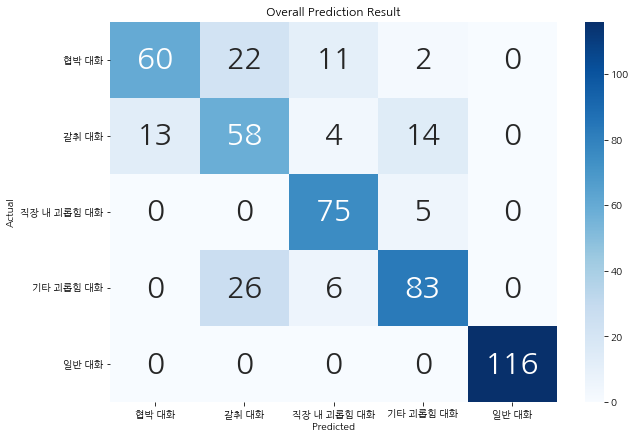

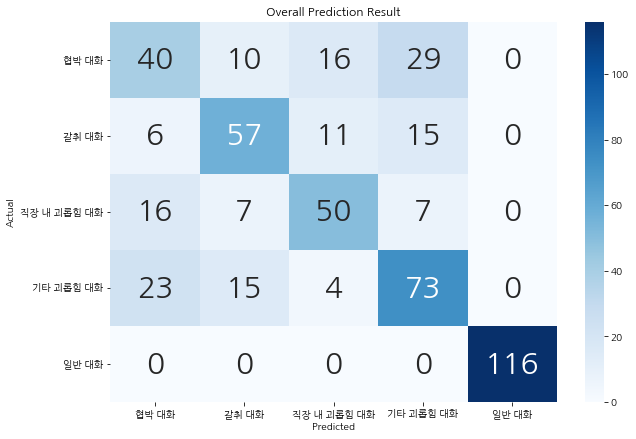

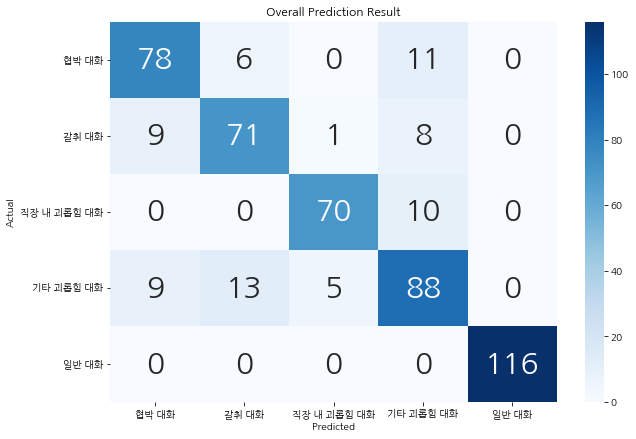

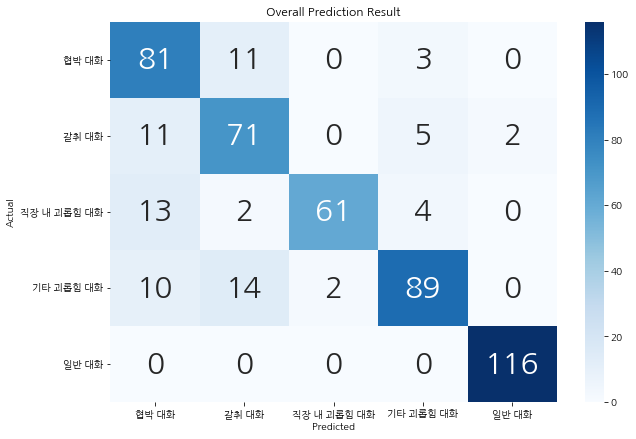

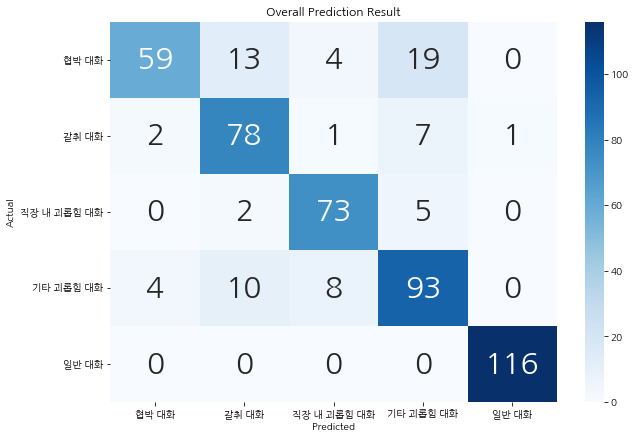

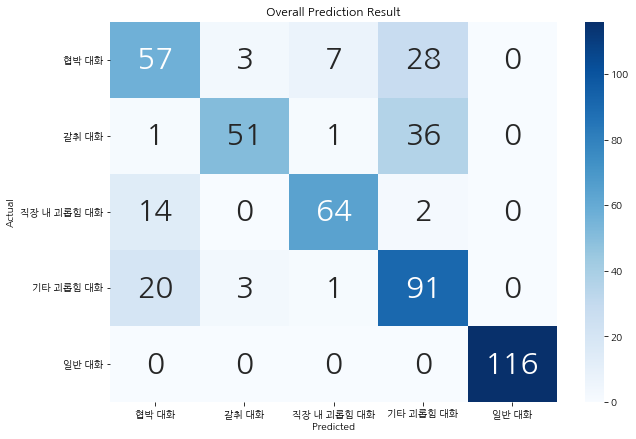

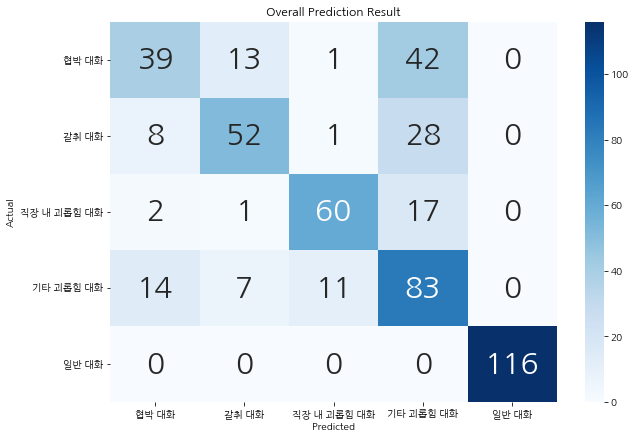

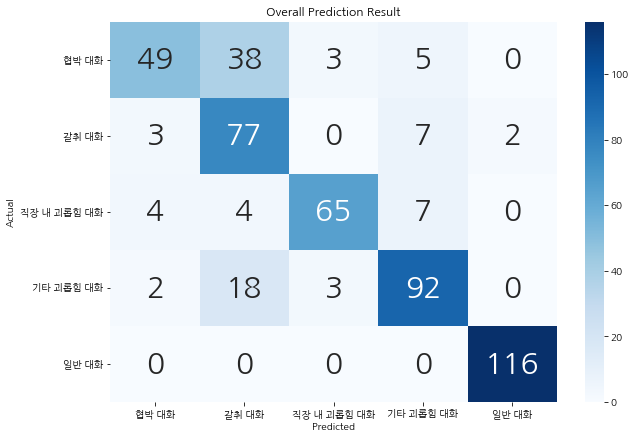

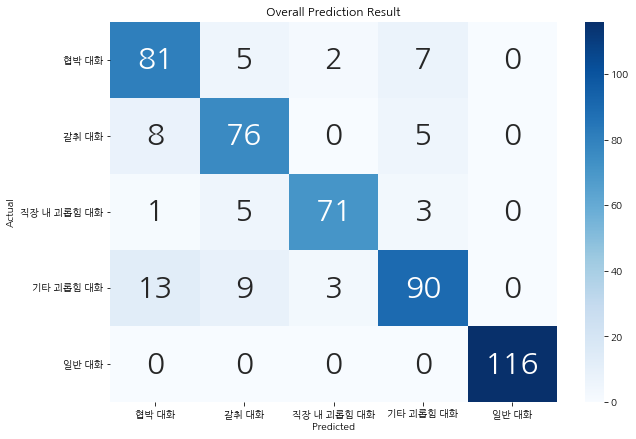

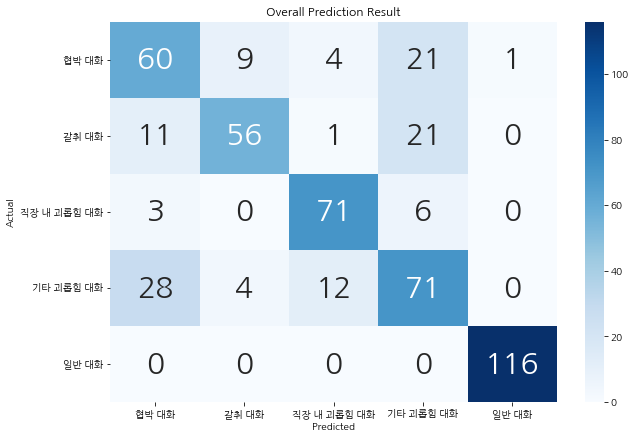

In [36]:
# train()에 인자가 있으므로 wrapper function 정의
def sweep_train():
    train(default_config=default_config, X_test=X_test, y_test=y_test)

# 팀프로젝트 내에서 sweep 실행
sweep_id = wandb.sweep(sweep_config,
                       entity = 'aiffel_minions',
                       project = 'DLthon_1DCNN_GRU')


wandb.agent(sweep_id,
            function=sweep_train,
            count=10)